In [ ]:
import re
import pandas as pd
import numpy as np
def clean_text(column):
    for row in column:
# Split CamelCase Characters like ConcatenationOperator to Concatenation Operator
        row = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1',  str(row))).split()
        row = ' '.join(row)
# Replace tabs and newlines with a single space
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()
# Remove the special characters and numbers 
        row = re.sub(r"[<>()|&©ø\[\]\'\",.\}`$\{;@?~*!+=_\//1234567890]", " ", str(row)).lower()
# Remove Repeated words
        row = re.sub(r"\\b(\\w+)(?:\\W+\\1\\b)+", "", str(row)).lower()
# Remove punctuation at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()
# Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()
# Remove the single character (any character) between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()
        yield row

In [ ]:
df_code = pd.read_csv('/content/drive/MyDrive/nlp/project/ALGO_ZENITH_BOOTCAMP_DATASET/javascript_Sample_Dataset.csv')
#extract only the code and docstring columns
df_code_p = df_code[["code","docstring"]]
print (df_code_p["docstring"][0])

Find the next separator: space, parens, comma, colon, double-quote, dollar, brackets


In [ ]:
#call clean_text function
processed_code= clean_text(df_code_p['code'])
processed_summary = clean_text(df_code_p['docstring'])
import spacy
from time import time
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
# Process the text as batches, you may should the batchsize when you use the complete dataset, empirically can be set to 5000 for > 1,00,000 records
code = [str(doc) for doc in nlp.pipe(processed_code, batch_size=50)]
#_START_ and _END_ tokens are markers to understand start and end of summaries
summary = [ str(doc) for doc in nlp.pipe(processed_summary, batch_size=50)]

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [ ]:
code_count=[]
for sent in df_code_p['code']:
    code_count.append(len(sent.split()))

In [ ]:
import matplotlib.pyplot as plt


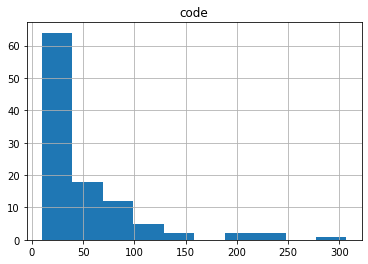

In [ ]:
histogram_df = pd.DataFrame()
histogram_df['code'] = code_count
histogram_df.hist(bins = 10)
plt.show()

In [ ]:
max_code_len = 100
max_summary_len =25
# Extract the codes and summaries within the maximum length
import numpy as np
cleaned_code = np.array(df_code_p['code'])
cleaned_summary= np.array(df_code_p['docstring'])
short_text = []
short_summary = []
for i in range(len(cleaned_code)):
  if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_code[i].split()) <= max_code_len:
    short_text.append(cleaned_code[i])
    short_summary.append(cleaned_summary[i])
    post_code = pd.DataFrame({'code': short_text,'summary': short_summary})
    post_code.head(100)
    #apply start and end markers
    post_code['summary'] = post_code['summary'].apply(lambda x: 'sostok ' + x \
    + ' eostok')
post_code.head(2)




,code,summary
0,function show(url) {\n const location = get('...,sostok show eostok
1,"function(_url,_href){\n if (!_url) ...",sostok check event need delegated eostok


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
t  = Tokenizer()

fit_text = 'Machine Learning'

t.fit_on_texts(fit_text)

print("Count of characters:",t.word_counts)
print("Length of text:",t.document_count)
print("Character index",t.word_index)
print("Frequency of characters:",t.word_docs)

Count of characters: OrderedDict([('m', 1), ('a', 2), ('c', 1), ('h', 1), ('i', 2), ('n', 3), ('e', 2), ('l', 1), ('r', 1), ('g', 1)])
Length of text: 16
Character index {'n': 1, 'a': 2, 'i': 3, 'e': 4, 'm': 5, 'c': 6, 'h': 7, 'l': 8, 'r': 9, 'g': 10}
Frequency of characters: defaultdict(<class 'int'>, {'m': 1, 'a': 2, 'c': 1, 'h': 1, 'i': 2, 'n': 3, 'e': 2, 'l': 1, 'r': 1, 'g': 1})


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(
np.array(post_code["code"]),
np.array(post_code["summary"]),
test_size=0.15,
random_state=0,
shuffle=True,
)

In [ ]:
# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
threshold = 2
cnt_infrequent = 0
total_cnt = 0
for key, value in x_tokenizer.word_counts.items():
    total_cnt = total_cnt + 1
    if value < threshold:
       cnt_infrequent = cnt_infrequent + 1
print("% of not frequent words in vocabulary: ", (cnt_infrequent / total_cnt) * 100)
# Remove the infrequent words
x_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent)
x_tokenizer.fit_on_texts(list(x_train))
# Convert the code sequences to integer sequences (integer numbers ranging from 1 to the maximum vocab sizes)
x_train_seqs = x_tokenizer.texts_to_sequences(x_train)
x_validation_seqs = x_tokenizer.texts_to_sequences(x_validation)
# printing the integer sequences
print (x_train_seqs)

# Pad zero upto maximum length
x_train = pad_sequences(x_train_seqs,  maxlen=max_code_len, padding='post')
x_validation = pad_sequences(x_validation_seqs, maxlen=max_code_len, padding='post')
# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1
print("Size of vocabulary in X = {}".format(x_voc))

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
threshold = 2
cnt_infrequent = 0
total_cnt = 0
for key, value in y_tokenizer.word_counts.items():
    total_cnt = total_cnt + 1
    if value < threshold:
        cnt_infrequent = cnt_infrequent + 1
y_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent)
y_tokenizer.fit_on_texts(list(y_train))
y_train_seqs = y_tokenizer.texts_to_sequences(y_train)
y_validation_seqs = y_tokenizer.texts_to_sequences(y_validation)
y_train = pad_sequences(y_train_seqs,  maxlen=max_summary_len, padding='post')
y_validation = pad_sequences(y_validation_seqs, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1
print("Size of vocabulary in Y = {}".format(y_voc))

print(len(x_train))
print(len(y_train))
print(len(x_validation))
print(len(y_validation))
# vocab sizes for x and y are 356 ans 105, hence highest integer value would be less than that. Also the maximum lengths of x and y are different
print((x_train[0]))
print((y_train[0]))

% of not frequent words in vocabulary:  44.2159383033419
[[3, 129, 130, 2, 20, 73, 20, 131, 132, 132, 131, 129, 38, 130, 23, 9, 9], [3, 39, 74, 24, 39, 39, 2, 21, 133, 39, 39, 39, 4, 21, 19, 21, 39, 3, 134, 4, 134, 74, 24], [3, 135, 5, 14, 28, 21, 55, 135, 3, 75, 2, 75, 4, 2, 14, 14, 75, 40, 14, 136, 14, 75, 4, 14], [3, 137, 138, 56, 1, 35, 137, 138, 1, 56, 56], [3, 46, 2, 29, 46, 47, 1, 139, 46, 2, 1, 48, 4, 76, 5, 140, 1, 1, 100, 1, 100, 141, 1, 1, 48, 1, 100, 19, 1, 140, 4, 49], [3, 15, 101, 102, 36, 5, 77, 15, 142, 143, 2, 101, 15, 102, 36, 30, 25, 144, 145, 146, 147, 41, 103, 148, 3, 78, 149, 42, 150, 151, 152, 153, 154, 155, 156, 157, 78, 158, 77, 9, 102, 159, 101, 104, 15, 15, 19, 77, 79, 104, 15, 15, 141, 77, 79, 160, 15, 23, 79, 57, 161, 14, 15, 36, 36], [3, 10, 2, 10, 4, 1, 10, 56, 80, 10, 41, 26, 21, 55, 3, 6, 2, 10, 6, 4, 1, 10, 6, 10, 6, 10, 6, 1], [3, 1, 162, 49, 1, 162, 55, 1, 58, 1, 1, 31, 103, 59, 1, 55, 1, 58, 1, 1], [3, 81, 5, 163, 81, 1, 10, 81, 1, 10, 164, 163, 3, 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from torch import nn

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, x_voc,y_voc,latent_dim,embedding_dim):
        super(EncoderDecoder,self).__init__()
        self.x_voc=x_voc
        self.y_voc=y_voc
        self.lstm_size = latent_dim
        self.embedding_dim = embedding_dim
        self.num_layers = 3

        # n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=self.x_voc,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.4,
        )

        self.dec_emb_layer = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x,y, prev_state):
        embed_x = self.embedding(x)
        output_x, state_x = self.lstm(embed_x,prev_state)
        embed_y=self.embedding(y)
        output_y,state=self.lstm(embed_y,state_x,num_layers=1)
        output=self.fc(output_y)

        # logits = output
        return output, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [ ]:
latent_dim = 300
embedding_dim = 200
# Encoder
encoder_inputs = Input(shape=(max_code_len, ))
# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
trainable=True)(encoder_inputs)
# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)
# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)
# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
return_sequences=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)
# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))
# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(
[x_train, y_train[:, :-1]],
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
epochs=50,
callbacks=[es],
batch_size=128,
validation_data=([x_validation, y_validation[:, :-1]],
y_validation.reshape(y_validation.shape[0], y_validation.shape[1], 1)[:
, 1:]),
)

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
state_h, state_c])
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_code_len, latent_dim))
# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
initial_state=[decoder_state_input_h, decoder_state_input_c])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  (e_out, e_h, e_c) = encoder_model.predict(input_seq)
  # Generate empty target sequence of length 1
  target_seq = np.zeros((1, 1))
  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = target_word_index['sostok']
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      (output_tokens, h, c) = decoder_model.predict([target_seq]+ [e_out, e_h, e_c])
  # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_word_index[sampled_token_index]
      if sampled_token != 'eostok':
          decoded_sentence += ' ' + sampled_token
    # Exit condition: either hit max length or find the stop word.
      if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_summary_len - 1:
          stop_condition = True
    # Update the target sequence (of length 1)
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] = sampled_token_index
    # Update internal states
      (e_h, e_c) = (h, c)
  return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
        != target_word_index['eostok']:
             newString = newString + reverse_target_word_index[i] + ' '
    return newString
# To convert sequence to text
def seq2text(input_seq):
     newString = ''
     for i in input_seq:
         if i != 0:
             newString = newString + reverse_source_word_index[i] + ' '
     return newString

In [ ]:
total_bleu_score = 0
diff = 0
for i in range(len(Test_code_comment)):
    pred = translate(transformer, Test_code_comment[i][0])
    bleu_score = (sacrebleu.sentence_bleu(pred, [Test_code_comment[i][1]], smooth_method='exp')).score
    print(bleu_score)
    total_bleu_score += bleu_score


In [1]:
print(f"Total test bleu score = {total_bleu_score/(len(Test_code_comment)-diff):.4f}")

Total test bleu score = 13.0074
